## --Version 4

Trial 5 Complete [00h 11m 24s]
val_loss: 1.1797730792295624e-07

Best val_loss So Far: 1.1436231517336637e-07
Total elapsed time: 00h 40m 56s

        Search complete. Optimal parameters:
        - LSTM Units 1: 224
        - LSTM Units 2: 112
        - Dropout: 0.20
        - Learning Rate: 0.00140
        - Batch Norm: True
        
Epoch 1/5
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 205s 172ms/step - loss: 0.0024 - mae: 0.0207 - mse: 0.0048 - val_loss: 1.1650e-07 - val_mae: 3.2942e-04 - val_mse: 2.3300e-07 - learning_rate: 0.0014
Epoch 2/5
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 178s 157ms/step - loss: 3.5742e-07 - mae: 2.9367e-04 - mse: 7.1483e-07 - val_loss: 1.1490e-07 - val_mae: 3.2615e-04 - val_mse: 2.2981e-07 - learning_rate: 0.0014
Epoch 3/5
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 176s 155ms/step - loss: 1.0492e-07 - mae: 2.6445e-04 - mse: 2.0985e-07 - val_loss: 1.1440e-07 - val_mae: 3.2906e-04 - val_mse: 2.2880e-07 - learning_rate: 0.0014
Epoch 4/5
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 186s 164ms/step - loss: 1

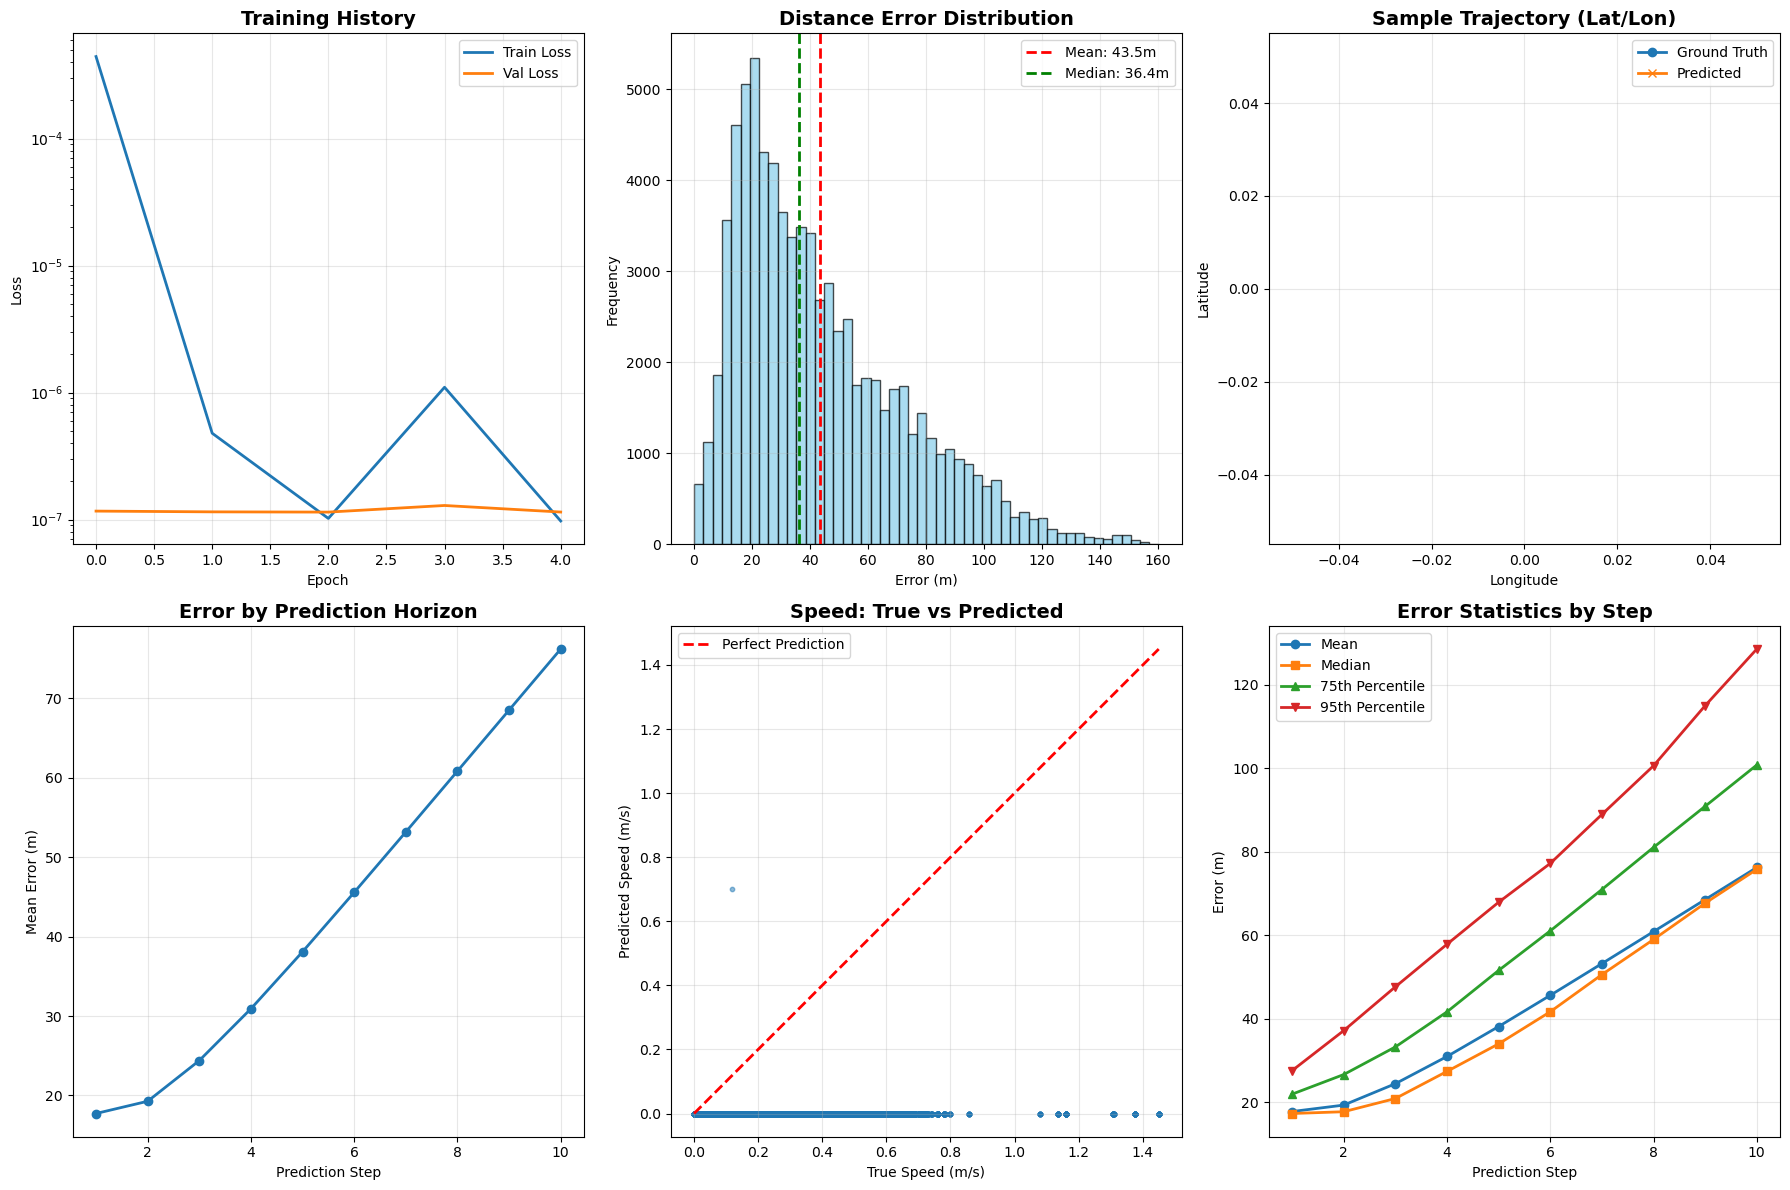

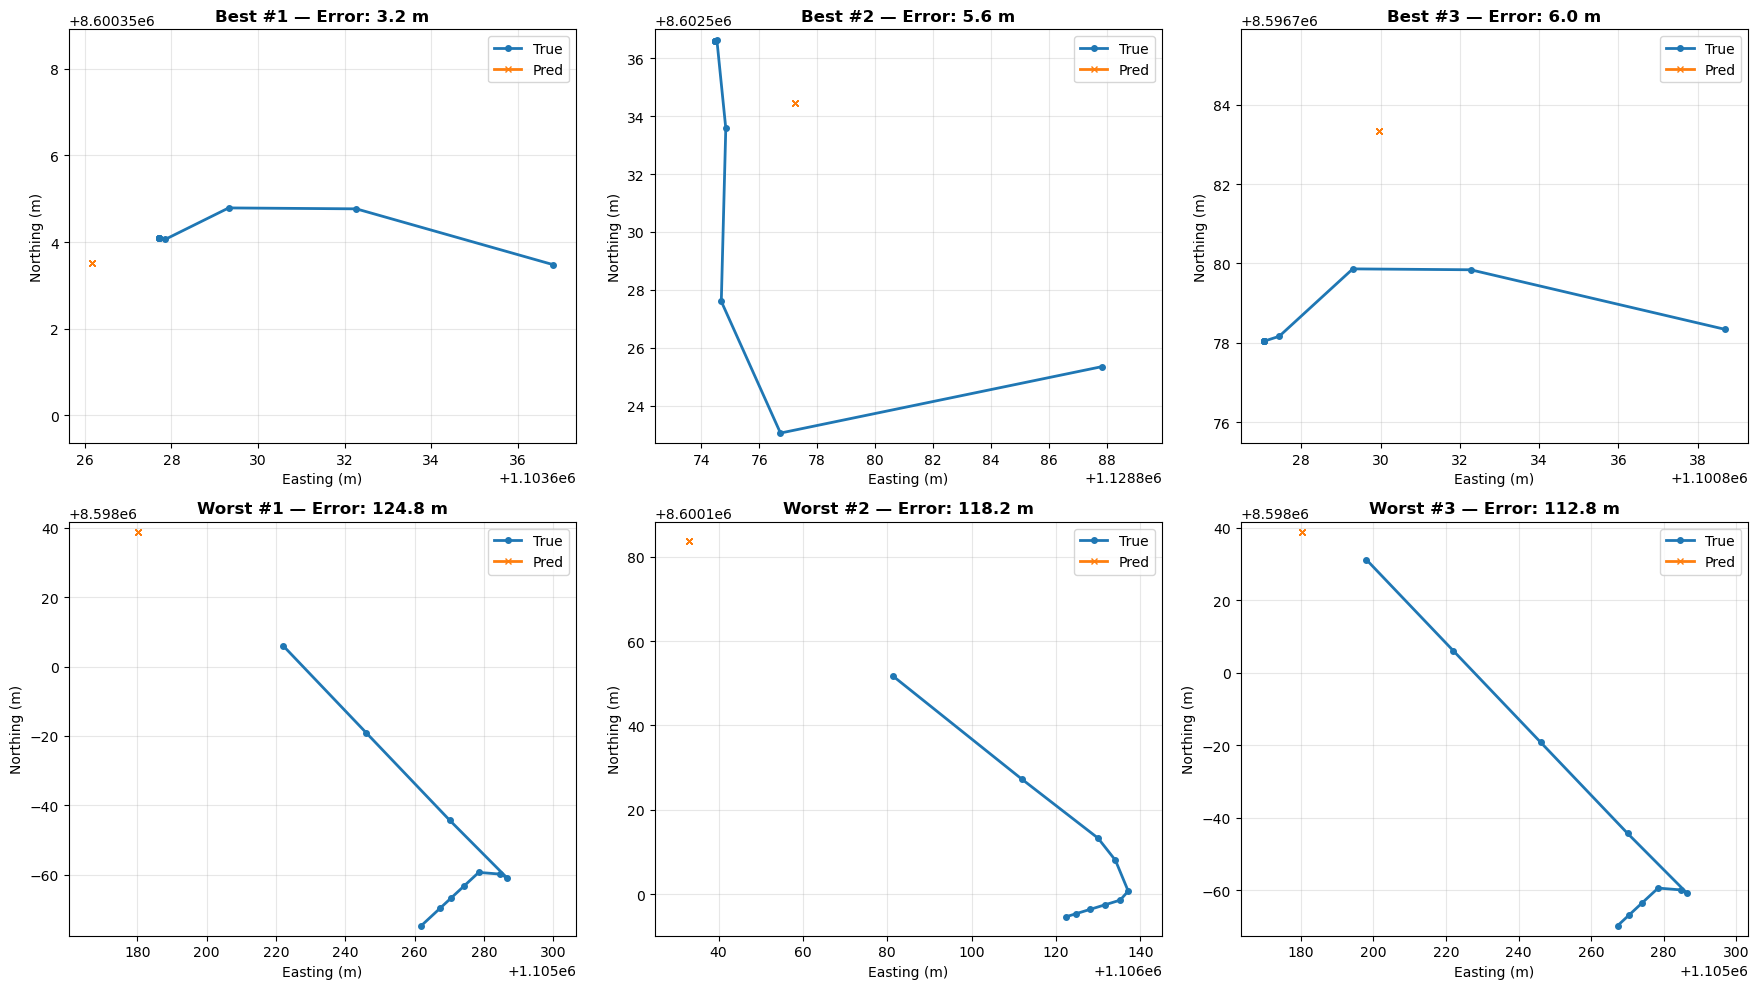


Model Summary:
- Input features: 15
- Features used: ['UTM_EASTING', 'UTM_NORTHING', 'VEL_UTM_E', 'VEL_UTM_N', 'SPEED_UTM', 'HEADING', 'ACCEL_UTM_E', 'ACCEL_UTM_N', 'ACCEL_MAGNITUDE', 'HOUR_SIN', 'HOUR_COS', 'DAY_SIN', 'DAY_COS', 'MONTH_SIN', 'MONTH_COS']
- Total parameters: 493,138
- Training samples: 36,318
- Validation samples: 7,782
- Test samples: 7,783

Performance vs Original:
- Your original mean error: 151.32 m
- Improved model mean error: 43.46 m
- Improvement: 71.3%


In [11]:
import os, glob, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler
import utm
from scipy.signal import savgol_filter
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)

# ─────────────────────────── IMPROVED CONFIG ────────────────────────────────
RAW_FOLDER, LOOK_BACK, FORECAST_HORIZON, FREQ = "Raw Data", 60, 10, "30s"  # Increased lookback, reduced horizon
MIN_SEQUENCE_LEN, VELOCITY_FEATURE, TIME_FEATURES = 150, True, True  # Increased min sequence
MAX_TIME_GAP = pd.Timedelta("5min")
MAX_SPEED = 5  # m/s - realistic max speed for filtering
MAX_ACCELERATION = 5  # m/s^2 - realistic max acceleration

# ──────────────────────── IMPROVED UTM utilities ────────────────────────────
def lat_lon_to_utm(lat, lon, zone_number=None, zone_letter=None):
    """Convert single lat/lon to UTM with optional forced zone"""
    if zone_number and zone_letter:
        return utm.from_latlon(lat, lon, force_zone_number=zone_number, force_zone_letter=zone_letter)
    return utm.from_latlon(lat, lon)

def utm_to_lat_lon(easting, northing, zone_number, zone_letter):
    """Convert UTM coordinates back to lat/lon."""
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

def add_utm_coordinates(df):
    """Improved UTM conversion with better error handling"""
    df = df.copy()
    if df.empty or df['LAT'].isna().all() or df['LONG'].isna().all():
        raise ValueError("No valid coordinate data")
    
    valid_coords = df[['LAT', 'LONG']].dropna()
    if len(valid_coords) == 0:
        raise ValueError("No valid coordinates for UTM conversion")
    
    # Determine UTM zone from center of data
    center_lat = valid_coords['LAT'].mean()
    center_lon = valid_coords['LONG'].mean()
    _, _, zone_number, zone_letter = utm.from_latlon(center_lat, center_lon)
    
    # Convert all coordinates to UTM
    utm_coords = []
    for _, row in valid_coords.iterrows():
        try:
            easting, northing, _, _ = utm.from_latlon(
                row['LAT'], row['LONG'], 
                force_zone_number=zone_number, 
                force_zone_letter=zone_letter
            )
            utm_coords.append((easting, northing))
        except:
            utm_coords.append((np.nan, np.nan))
    
    utm_coords = np.array(utm_coords)
    df.loc[valid_coords.index, 'UTM_EASTING'] = utm_coords[:, 0]
    df.loc[valid_coords.index, 'UTM_NORTHING'] = utm_coords[:, 1]
    df['UTM_ZONE_NUM'] = zone_number
    df['UTM_ZONE_LETTER'] = zone_letter
    
    # Remove invalid conversions
    df = df.dropna(subset=['UTM_EASTING', 'UTM_NORTHING'])
    return df

# ──────────────────────── IMPROVED Data Loading ───────────────────────────
def load_and_split_journeys():
    """Improved data loading with better filtering"""
    csvs = sorted(glob.glob(os.path.join(RAW_FOLDER, "*.csv")))
    print(f"Found {len(csvs)} CSV files.")
    if not csvs:
        raise FileNotFoundError(f"No CSVs in {RAW_FOLDER}")
    
    all_journeys = []
    
    for p in csvs:
        print(f"Processing file: {os.path.basename(p)}")
        try:
            df = pd.read_csv(p)
        except Exception as e:
            print(f"Error reading {p}: {e}")
            continue
        
        # Find column names (case insensitive)
        cols = {c.lower(): c for c in df.columns}
        t = next((cols[k] for k in cols if any(x in k for x in ("time","date"))), None)
        la = next((cols[k] for k in cols if "lat" in k), None)
        lo = next((cols[k] for k in cols if any(x in k for x in ("lon","long"))), None)
        
        if not (t and la and lo):
            print(f"Missing required columns in {p}")
            continue
        
        # Select and rename columns
        df = df[[t, la, lo]].rename(columns={t: "TIME", la: "LAT", lo: "LONG"})
        
        # Convert data types
        df["TIME"] = pd.to_datetime(df["TIME"], errors="coerce")
        df["TIME"] = df["TIME"].dt.tz_localize(None)
        df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")
        df["LONG"] = pd.to_numeric(df["LONG"], errors="coerce")
        
        # Remove invalid data
        df = df.dropna().reset_index(drop=True)
        df = df[(df["LAT"].between(-90, 90)) & (df["LONG"].between(-180, 180))]
        
        if len(df) < MIN_SEQUENCE_LEN:
            print(f"Journey too short: {len(df)} < {MIN_SEQUENCE_LEN}")
            continue
        
        # Set time index and remove duplicates
        df = df.set_index("TIME").sort_index()
        df = df[~df.index.duplicated(keep='first')]
        
        # Improved outlier removal using IQR method
        for ax in ("LAT", "LONG"):
            if len(df) > 10:
                Q1 = df[ax].quantile(0.25)
                Q3 = df[ax].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 2.5 * IQR  # More conservative outlier removal
                upper = Q3 + 2.5 * IQR
                df = df[(df[ax] >= lower) & (df[ax] <= upper)]
        
        if len(df) < MIN_SEQUENCE_LEN:
            continue
        
        try:
            df = add_utm_coordinates(df)
        except Exception as e:
            print(f"UTM conversion failed for {p}: {e}")
            continue
        
        # Split journeys based on time gaps
        time_diffs = df.index.to_series().diff()
        journey_breaks = (time_diffs > MAX_TIME_GAP).cumsum()
        
        for journey_id, journey_df in df.groupby(journey_breaks):
            if len(journey_df) >= LOOK_BACK + FORECAST_HORIZON:
                all_journeys.append(journey_df)
                print(f"Added journey with {len(journey_df)} points")
    
    if not all_journeys:
        raise ValueError("No usable journeys found in CSV files")
    
    print(f"Total journeys extracted: {len(all_journeys)}")
    return all_journeys

# ──────────────────────── IMPROVED Feature Engineering ───────────────────────────
def add_features(df):
    """Improved feature engineering with better velocity calculations"""
    out = df.copy()
    if len(out) < 7:
        return out
    
    # Parameters for Savitzky-Golay filter
    window = min(7, len(out) if len(out) % 2 == 1 else len(out) - 1)
    if window < 3:
        window = 3
    poly = min(2, window - 1)
    dt = pd.Timedelta(FREQ).total_seconds()
    
    if VELOCITY_FEATURE:
        # Calculate velocities using Savitzky-Golay filter
        try:
            out["VEL_UTM_E"] = savgol_filter(out["UTM_EASTING"], window, poly, deriv=1, delta=dt)
            out["VEL_UTM_N"] = savgol_filter(out["UTM_NORTHING"], window, poly, deriv=1, delta=dt)
            
            # Calculate speed and heading
            out["SPEED_UTM"] = np.sqrt(out["VEL_UTM_E"]**2 + out["VEL_UTM_N"]**2)
            out["HEADING"] = np.arctan2(out["VEL_UTM_N"], out["VEL_UTM_E"])
            
            # Calculate accelerations
            out["ACCEL_UTM_E"] = savgol_filter(out["UTM_EASTING"], window, poly, deriv=2, delta=dt)
            out["ACCEL_UTM_N"] = savgol_filter(out["UTM_NORTHING"], window, poly, deriv=2, delta=dt)
            out["ACCEL_MAGNITUDE"] = np.sqrt(out["ACCEL_UTM_E"]**2 + out["ACCEL_UTM_N"]**2)
            
            # Filter unrealistic speeds and accelerations
            speed_mask = out["SPEED_UTM"] <= MAX_SPEED
            accel_mask = out["ACCEL_MAGNITUDE"] <= MAX_ACCELERATION
            valid_mask = speed_mask & accel_mask
            
            if valid_mask.sum() < len(out) * 0.8:  # If too many points are filtered
                print(f"Warning: {len(out) - valid_mask.sum()} points filtered due to unrealistic speeds/accelerations")
            
            # Apply filters
            for col in ["VEL_UTM_E", "VEL_UTM_N", "SPEED_UTM", "ACCEL_UTM_E", "ACCEL_UTM_N", "ACCEL_MAGNITUDE"]:
                out.loc[~valid_mask, col] = np.nan
            
        except Exception as e:
            print(f"Error calculating velocities: {e}")
            # Fallback to simple difference method
            out["VEL_UTM_E"] = out["UTM_EASTING"].diff() / dt
            out["VEL_UTM_N"] = out["UTM_NORTHING"].diff() / dt
            out["SPEED_UTM"] = np.sqrt(out["VEL_UTM_E"]**2 + out["VEL_UTM_N"]**2)
            out["HEADING"] = np.arctan2(out["VEL_UTM_N"], out["VEL_UTM_E"])
            out["ACCEL_UTM_E"] = out["VEL_UTM_E"].diff() / dt
            out["ACCEL_UTM_N"] = out["VEL_UTM_N"].diff() / dt
            out["ACCEL_MAGNITUDE"] = np.sqrt(out["ACCEL_UTM_E"]**2 + out["ACCEL_UTM_N"]**2)
    
    if TIME_FEATURES:
        # Cyclical time features
        out["HOUR_SIN"] = np.sin(2 * np.pi * out.index.hour / 24)
        out["HOUR_COS"] = np.cos(2 * np.pi * out.index.hour / 24)
        out["DAY_SIN"] = np.sin(2 * np.pi * out.index.dayofweek / 7)
        out["DAY_COS"] = np.cos(2 * np.pi * out.index.dayofweek / 7)
        out["MONTH_SIN"] = np.sin(2 * np.pi * out.index.month / 12)
        out["MONTH_COS"] = np.cos(2 * np.pi * out.index.month / 12)
    
    # Fill missing values more carefully
    numeric_cols = out.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Forward fill, then backward fill, then fill remaining with median
        out[col] = out[col].fillna(method="ffill").fillna(method="bfill").fillna(out[col].median())
    
    return out

# ─────────────────────── IMPROVED Model Definition ─────────────────────────────
class ImprovedUTMGPSPredictor:
    def __init__(self, lb=LOOK_BACK, hz=FORECAST_HORIZON):
        self.lb, self.hz = lb, hz
        self.x_scaler = RobustScaler()  # More robust to outliers
        self.utm_scaler = RobustScaler()
        self.features, self.model = [], None
        self.utm_zone_num = None
        self.utm_zone_letter = None

    def _build_for_tuning(self, hp):
        """Improved model architecture with better hyperparameter ranges"""
        # More reasonable hyperparameter ranges
        lstm_units_1 = hp.Int('lstm_units_1', min_value=64, max_value=256, step=32)
        lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
        dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
        learning_rate = hp.Float('lr', min_value=1e-4, max_value=5e-3, sampling='log')
        
        # Add batch normalization option
        use_batch_norm = hp.Boolean('batch_norm')
        
        # Model architecture
        encoder_inputs = tf.keras.layers.Input(shape=(self.lb, self.n_feat_))
        
        # First LSTM layer
        x = tf.keras.layers.LSTM(lstm_units_1, return_sequences=True, dropout=dropout_rate)(encoder_inputs)
        if use_batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        
        # Second LSTM layer with state outputs
        encoder_lstm2, state_h, state_c = tf.keras.layers.LSTM(
            lstm_units_2, return_sequences=True, return_state=True, dropout=dropout_rate
        )(x)
        encoder_states = [state_h, state_c]
        
        # Decoder with attention
        decoder_inputs = tf.keras.layers.RepeatVector(self.hz)(state_h)
        decoder_lstm = tf.keras.layers.LSTM(
            lstm_units_2, return_sequences=True, dropout=dropout_rate
        )(decoder_inputs, initial_state=encoder_states)
        
        # Attention mechanism
        attention = tf.keras.layers.Attention()([decoder_lstm, encoder_lstm2])
        context_vector = tf.keras.layers.Concatenate(axis=-1)([decoder_lstm, attention])
        
        # Dense layers before output
        x = tf.keras.layers.Dense(lstm_units_2, activation='relu')(context_vector)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        
        # Output layer (predicting 2D coordinates)
        output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))(x)
        
        model = tf.keras.Model(encoder_inputs, output_layer)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),  # Gradient clipping
            loss='huber',
            metrics=['mae', 'mse']
        )
        return model

    def make_xy_delta_based(self, journeys):
        """Improved sequence generation with better validation"""
        all_X, all_y = [], []
        
        if not journeys:
            raise ValueError("No journeys provided")
        
        # Get UTM zone from first journey
        first_journey = journeys[0]
        self.utm_zone_num = first_journey['UTM_ZONE_NUM'].iloc[0]
        self.utm_zone_letter = first_journey['UTM_ZONE_LETTER'].iloc[0]
        
        # Define features
        self.features = ["UTM_EASTING", "UTM_NORTHING"]
        if VELOCITY_FEATURE:
            velocity_features = ["VEL_UTM_E", "VEL_UTM_N", "SPEED_UTM", "HEADING", 
                               "ACCEL_UTM_E", "ACCEL_UTM_N", "ACCEL_MAGNITUDE"]
            # Only add features that exist in the data
            for feat in velocity_features:
                if feat in first_journey.columns:
                    self.features.append(feat)
        
        if TIME_FEATURES:
            time_features = ["HOUR_SIN", "HOUR_COS", "DAY_SIN", "DAY_COS", "MONTH_SIN", "MONTH_COS"]
            for feat in time_features:
                if feat in first_journey.columns:
                    self.features.append(feat)
        
        print(f"Using features: {self.features}")
        
        # Collect all data for fitting scalers
        all_features = []
        all_utm_coords = []
        
        for journey in journeys:
            # Check if all features exist
            missing_features = [f for f in self.features if f not in journey.columns]
            if missing_features:
                print(f"Warning: Missing features {missing_features} in journey")
                continue
            
            journey_features = journey[self.features].values
            journey_utm = journey[["UTM_EASTING", "UTM_NORTHING"]].values
            
            # Check for NaN values
            if np.isnan(journey_features).any() or np.isnan(journey_utm).any():
                print("Warning: NaN values found in journey data")
                continue
                
            all_features.append(journey_features)
            all_utm_coords.append(journey_utm)
        
        if not all_features:
            raise ValueError("No valid journey data found")
        
        # Fit scalers
        combined_features = np.vstack(all_features)
        combined_utm = np.vstack(all_utm_coords)
        
        self.x_scaler.fit(combined_features)
        self.utm_scaler.fit(combined_utm)
        
        # Generate sequences
        for journey in journeys:
            if not all(f in journey.columns for f in self.features):
                continue
                
            journey_features = journey[self.features].values
            journey_utm = journey[["UTM_EASTING", "UTM_NORTHING"]].values
            
            if np.isnan(journey_features).any() or np.isnan(journey_utm).any():
                continue
            
            # Scale features
            X_scaled = self.x_scaler.transform(journey_features)
            utm_scaled = self.utm_scaler.transform(journey_utm)
            
            # Create sequences
            for i in range(len(journey) - self.lb - self.hz + 1):
                X_seq = X_scaled[i:i+self.lb]
                
                # Base position for delta calculation
                base_position = utm_scaled[i+self.lb-1]
                future_absolute = utm_scaled[i+self.lb:i+self.lb+self.hz]
                future_deltas = future_absolute - base_position
                
                all_X.append(X_seq)
                all_y.append(future_deltas)
        
        if not all_X:
            raise ValueError("No sequences generated")
        
        print(f"Generated {len(all_X)} sequences")
        return np.array(all_X), np.array(all_y)

    def train_with_tuning(self, X_train, y_train, X_val, y_val):
        """Improved training with better hyperparameter search"""
        self.n_feat_ = X_train.shape[-1]
        
        tuner = kt.RandomSearch(
            self._build_for_tuning,
            objective='val_loss',
            max_trials=5,  # Increased trials
            executions_per_trial=1,
            directory='keras_tuner_dir',
            project_name='improved_gps_tuning_upd'
        )

        # Better callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-2)
        ]

        print("\n--- Starting Hyperparameter Search ---")
        tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=3, callbacks=callbacks)

        # Get best model and train longer
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"""
        Search complete. Optimal parameters:
        - LSTM Units 1: {best_hps.get('lstm_units_1')}
        - LSTM Units 2: {best_hps.get('lstm_units_2')}
        - Dropout: {best_hps.get('dropout'):.2f}
        - Learning Rate: {best_hps.get('lr'):.5f}
        - Batch Norm: {best_hps.get('batch_norm')}
        """)

        # Build and train final model
        self.model = tuner.hypermodel.build(best_hps)
        hist = self.model.fit(
            X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=5,  # More epochs for final training
            callbacks=callbacks,
            batch_size=32,
            verbose=1
        )
        return hist

    def predict_utm_deltas(self, X):
        """Predict UTM coordinate deltas"""
        return self.model.predict(X, batch_size=32)

    def predict_utm_absolute(self, X, last_positions):
        """Predict absolute UTM coordinates from deltas"""
        deltas_scaled = self.predict_utm_deltas(X)
        
        # Reshape and unscale deltas
        n_samples, horizon, n_dims = deltas_scaled.shape
        deltas_scaled_flat = deltas_scaled.reshape(n_samples * horizon, n_dims)
        deltas_unscaled_flat = self.utm_scaler.inverse_transform(deltas_scaled_flat)
        deltas_unscaled = deltas_unscaled_flat.reshape(n_samples, horizon, n_dims)
        
        # Add deltas to base positions
        absolute_predictions = last_positions[:, np.newaxis, :] + deltas_unscaled
        return absolute_predictions

    def predict_latlon(self, X, last_positions):
        """Predict and convert to lat/lon coordinates"""
        utm_pred = self.predict_utm_absolute(X, last_positions)
        lat_lon_pred = np.zeros_like(utm_pred)
        
        for i in range(utm_pred.shape[0]):
            for j in range(utm_pred.shape[1]):
                easting, northing = utm_pred[i, j]
                try:
                    lat, lon = utm_to_lat_lon(easting, northing, self.utm_zone_num, self.utm_zone_letter)
                    lat_lon_pred[i, j] = [lat, lon]
                except:
                    lat_lon_pred[i, j] = [np.nan, np.nan]
        
        return lat_lon_pred

# ───────────────────────────── IMPROVED Metrics ───────────────────────────
def calculate_improved_metrics(y_true_utm, y_pred_utm, time_step_seconds=30):
    """Calculate comprehensive metrics"""
    results = {}
    
    # Distance errors
    distances = np.sqrt(np.sum((y_true_utm - y_pred_utm)**2, axis=-1))
    results['distance_errors'] = distances
    results['mean_distance_error'] = np.mean(distances)
    results['median_distance_error'] = np.median(distances)
    results['std_distance_error'] = np.std(distances)
    results['percentile_95'] = np.percentile(distances, 95)
    results['percentile_99'] = np.percentile(distances, 99)
    
    # MAE and RMSE
    results['mae'] = mean_absolute_error(y_true_utm.reshape(-1, 2), y_pred_utm.reshape(-1, 2))
    results['rmse'] = np.sqrt(mean_squared_error(y_true_utm.reshape(-1, 2), y_pred_utm.reshape(-1, 2)))
    
    # Speed and bearing analysis
    if len(y_true_utm.shape) == 3:
        true_speeds, pred_speeds = [], []
        true_bearings, pred_bearings = [], []
        
        for i in range(y_true_utm.shape[0]):
            for j in range(1, y_true_utm.shape[1]):
                # Speed calculation
                true_delta = y_true_utm[i, j] - y_true_utm[i, j-1]
                pred_delta = y_pred_utm[i, j] - y_pred_utm[i, j-1]
                
                true_distance = np.linalg.norm(true_delta)
                pred_distance = np.linalg.norm(pred_delta)
                
                true_speed = true_distance / time_step_seconds
                pred_speed = pred_distance / time_step_seconds
                
                if true_speed < MAX_SPEED:  # Filter unrealistic speeds
                    true_speeds.append(true_speed)
                    pred_speeds.append(pred_speed)
                
                # Bearing calculation
                if np.linalg.norm(true_delta) > 1e-6:
                    true_bearing = np.arctan2(true_delta[1], true_delta[0])
                    pred_bearing = np.arctan2(pred_delta[1], pred_delta[0])
                    true_bearings.append(true_bearing)
                    pred_bearings.append(pred_bearing)
        
        if true_speeds:
            results['true_speeds'] = np.array(true_speeds)
            results['pred_speeds'] = np.array(pred_speeds)
            results['speed_errors'] = np.abs(np.array(true_speeds) - np.array(pred_speeds))
            results['mean_speed_error'] = np.mean(results['speed_errors'])
            results['median_speed_error'] = np.median(results['speed_errors'])
        
        if true_bearings:
            true_bearings = np.array(true_bearings)
            pred_bearings = np.array(pred_bearings)
            bearing_diffs = pred_bearings - true_bearings
            bearing_diffs = np.arctan2(np.sin(bearing_diffs), np.cos(bearing_diffs))
            bearing_errors_deg = np.abs(bearing_diffs) * 180 / np.pi
            results['bearing_errors_deg'] = bearing_errors_deg
            results['mean_bearing_error'] = np.mean(bearing_errors_deg)
            results['median_bearing_error'] = np.median(bearing_errors_deg)
    
    return results

# ──────────────────────── FIXED Plotting Function ─────────────────────────────
def plot_worst_predictions_utm(results, top_n=3):
    """Fixed plotting function"""
    y_true = results['y_true_utm']
    y_pred = results['y_hat_utm']

    # Calculate mean error per trajectory
    errors = np.linalg.norm(y_true - y_pred, axis=-1).mean(axis=1)
    worst_idx = np.argsort(errors)[-top_n:][::-1]

    for rank, idx in enumerate(worst_idx, start=1):  # Fixed: added rank variable
        true_utm = y_true[idx]
        pred_utm = y_pred[idx]
        err = errors[idx]

        plt.figure(figsize=(8, 6))
        plt.plot(true_utm[:,0], true_utm[:,1], '-o', label='True', markersize=4)
        plt.plot(pred_utm[:,0], pred_utm[:,1], '-x', label='Pred', markersize=4)
        plt.title(f"Worst #{rank} (idx={idx}) — Mean Error: {err:.1f} m")
        plt.xlabel("Easting (m)")
        plt.ylabel("Northing (m)")
        plt.axis('equal')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# ───────────────────────────── IMPROVED Main Run ───────────────────────────
def run_improved():
    """Main execution function with improvements"""
    print("Loading and processing journeys...")
    journeys = load_and_split_journeys()
    
    processed_journeys = []
    for i, journey in enumerate(journeys):
        print(f"Processing journey {i+1}/{len(journeys)}")
        
        # Resample to consistent frequency
        numeric_journey = journey.select_dtypes(include=[np.number])
        journey_resampled = numeric_journey.resample(FREQ).mean()
        journey_resampled = journey_resampled.interpolate("time", limit=10).dropna()
        
        # Preserve UTM zone info
        if 'UTM_ZONE_NUM' in journey.columns:
            journey_resampled['UTM_ZONE_NUM'] = journey['UTM_ZONE_NUM'].iloc[0]
            journey_resampled['UTM_ZONE_LETTER'] = journey['UTM_ZONE_LETTER'].iloc[0]
        
        # Add features
        journey_with_features = add_features(journey_resampled)
        
        if len(journey_with_features) >= LOOK_BACK + FORECAST_HORIZON:
            processed_journeys.append(journey_with_features)
            print(f"Journey {i+1} processed successfully: {len(journey_with_features)} points")
        else:
            print(f"Journey {i+1} too short after processing: {len(journey_with_features)} points")
    
    if not processed_journeys:
        raise RuntimeError("No journeys have enough data after processing")
    
    print(f"\nFinal processed journeys: {len(processed_journeys)}")
    
    # Create model and prepare data
    model = ImprovedUTMGPSPredictor()
    X, y = model.make_xy_delta_based(processed_journeys)
    
    # Split data
    train_split = int(len(X) * 0.7)
    val_split = int(len(X) * 0.85)
    
    X_train, y_train = X[:train_split], y[:train_split]
    X_val, y_val = X[train_split:val_split], y[train_split:val_split]
    X_test, y_test = X[val_split:], y[val_split:]
    
    print(f"\nDataset splits:")
    print(f"Training: {len(X_train)} sequences")
    print(f"Validation: {len(X_val)} sequences")
    print(f"Test: {len(X_test)} sequences")
    
    # Train model
    print("\nTraining improved model...")
    hist = model.train_with_tuning(X_train, y_train, X_val, y_val)
    
    # Prepare last positions for prediction
    last_positions = []
    for i in range(len(X_test)):
        # Get the last known position from the input sequence
        last_input_scaled = X_test[i][-1][:2]  # First 2 features are UTM coordinates
        last_pos_utm = model.utm_scaler.inverse_transform(last_input_scaled.reshape(1, -1)).flatten()
        last_positions.append(last_pos_utm)
    last_positions = np.array(last_positions)
    
    # Make predictions
    print("Making predictions...")
    y_hat_utm = model.predict_utm_absolute(X_test, last_positions)
    y_hat_latlon = model.predict_latlon(X_test, last_positions)
    
    # Convert true values to absolute coordinates
    y_true_utm = np.zeros_like(y_hat_utm)
    for i in range(len(y_test)):
        # Unscale the true deltas
        true_deltas_unscaled = model.utm_scaler.inverse_transform(y_test[i])
        # Reconstruct the absolute true path
        y_true_utm[i] = last_positions[i] + true_deltas_unscaled
    
    # Convert true UTM to lat/lon
    y_true_latlon = np.zeros_like(y_true_utm)
    for i in range(y_true_utm.shape[0]):
        for j in range(y_true_utm.shape[1]):
            easting, northing = y_true_utm[i, j]
            try:
                lat, lon = utm_to_lat_lon(easting, northing, model.utm_zone_num, model.utm_zone_letter)
                y_true_latlon[i, j] = [lat, lon]
            except:
                y_true_latlon[i, j] = [np.nan, np.nan]
    
    # Calculate metrics
    print("Calculating metrics...")
    metrics = calculate_improved_metrics(y_true_utm, y_hat_utm)
    
    # Print results
    print("\n" + "="*70)
    print("IMPROVED UTM-BASED GPS FORECASTER - RESULTS")
    print("="*70)
    print(f"\n📊 DATASET SUMMARY:")
    print(f" Processed journeys: {len(processed_journeys)}")
    print(f" Training sequences: {train_split}")
    print(f" Validation sequences: {val_split - train_split}")
    print(f" Test sequences: {len(X) - val_split}")
    print(f" Look-back: {LOOK_BACK} steps ({LOOK_BACK * 0.5:.1f} min)")
    print(f" Forecast: {FORECAST_HORIZON} steps ({FORECAST_HORIZON * 0.5:.1f} min)")
    
    print(f"\n🎯 DISTANCE ACCURACY:")
    print(f" Mean error: {metrics['mean_distance_error']:.2f} m")
    print(f" Median error: {metrics['median_distance_error']:.2f} m")
    print(f" Std deviation: {metrics['std_distance_error']:.2f} m")
    print(f" 95th percentile: {metrics['percentile_95']:.2f} m")
    print(f" 99th percentile: {metrics['percentile_99']:.2f} m")
    print(f" Max error: {np.max(metrics['distance_errors']):.2f} m")
    print(f" MAE: {metrics['mae']:.2f} m")
    print(f" RMSE: {metrics['rmse']:.2f} m")
    
    if 'speed_errors' in metrics:
        print(f"\n🚀 VELOCITY ACCURACY:")
        print(f" Mean speed error: {metrics['mean_speed_error']:.3f} m/s")
        print(f" Median speed error: {metrics['median_speed_error']:.3f} m/s")
        print(f" True speed range: {np.min(metrics['true_speeds']):.3f} - {np.max(metrics['true_speeds']):.3f} m/s")
        print(f" Pred speed range: {np.min(metrics['pred_speeds']):.3f} - {np.max(metrics['pred_speeds']):.3f} m/s")
    
    if 'bearing_errors_deg' in metrics:
        print(f"\n🧭 BEARING ACCURACY:")
        print(f" Mean bearing error: {metrics['mean_bearing_error']:.1f}°")
        print(f" Median bearing error: {metrics['median_bearing_error']:.1f}°")
    
    print(f"\n⏰ PREDICTION HORIZON ANALYSIS:")
    horizon_errors = np.mean(metrics['distance_errors'], axis=0)
    for step in [1, 3, 5, 7, 10]:
        if step <= len(horizon_errors):
            print(f" Step {step:2d} ({step * 0.5:.1f} min): {horizon_errors[step-1]:.1f} m")
    
    print(f"\n🏋️ TRAINING PERFORMANCE:")
    print(f" Final train loss: {hist.history['loss'][-1]:.6f}")
    print(f" Final val loss: {hist.history['val_loss'][-1]:.6f}")
    print(f" Epochs trained: {len(hist.history['loss'])}")
    print(f" Best epoch: {np.argmin(hist.history['val_loss']) + 1}")
    print("="*70)
    
    return {
        'hist': hist,
        'y_hat_utm': y_hat_utm,
        'y_true_utm': y_true_utm,
        'y_hat_latlon': y_hat_latlon,
        'y_true_latlon': y_true_latlon,
        'df_f': pd.concat(processed_journeys),
        'train_split': train_split,
        'val_split': val_split,
        'X': X,
        'model': model,
        'num_journeys': len(processed_journeys),
        'metrics': metrics,
        'last_positions': last_positions
    }

# ──────────────────────────── IMPROVED Plotting Functions ───────────────────────────
def plot_improved_comparison(results):
    """Comprehensive plotting for model analysis"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Training history
    axes[0, 0].plot(results['hist'].history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(results['hist'].history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Training History', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Distance error distribution
    metrics = results['metrics']
    axes[0, 1].hist(metrics['distance_errors'].flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].axvline(metrics['mean_distance_error'], color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {metrics["mean_distance_error"]:.1f}m')
    axes[0, 1].axvline(metrics['median_distance_error'], color='green', linestyle='--', linewidth=2,
                      label=f'Median: {metrics["median_distance_error"]:.1f}m')
    axes[0, 1].set_title('Distance Error Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Error (m)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Sample trajectory
    idx = np.argmax(np.std(results['y_true_latlon'], axis=1))
    y_true = results['y_true_latlon'][idx]
    y_pred = results['y_hat_latlon'][idx]
    axes[0, 2].plot(y_true[:, 1], y_true[:, 0], '-o', label='Ground Truth', markersize=6, linewidth=2)
    axes[0, 2].plot(y_pred[:, 1], y_pred[:, 0], '-x', label='Predicted', markersize=6, linewidth=2)
    axes[0, 2].set_title('Sample Trajectory (Lat/Lon)', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Longitude')
    axes[0, 2].set_ylabel('Latitude')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Error by prediction horizon
    horizon_errors = np.mean(metrics['distance_errors'], axis=0)
    axes[1, 0].plot(range(1, len(horizon_errors) + 1), horizon_errors, 'o-', linewidth=2, markersize=6)
    axes[1, 0].set_title('Error by Prediction Horizon', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Prediction Step')
    axes[1, 0].set_ylabel('Mean Error (m)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Speed comparison (if available)
    if 'speed_errors' in metrics:
        axes[1, 1].scatter(metrics['true_speeds'], metrics['pred_speeds'], alpha=0.5, s=10)
        max_speed = max(np.max(metrics['true_speeds']), np.max(metrics['pred_speeds']))
        axes[1, 1].plot([0, max_speed], [0, max_speed], 'r--', linewidth=2, label='Perfect Prediction')
        axes[1, 1].set_title('Speed: True vs Predicted', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('True Speed (m/s)')
        axes[1, 1].set_ylabel('Predicted Speed (m/s)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Speed data\nnot available', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Speed Analysis', fontsize=14, fontweight='bold')
    
    # Error statistics by step
    step_stats = []
    for step in range(metrics['distance_errors'].shape[1]):
        step_errors = metrics['distance_errors'][:, step]
        step_stats.append([
            np.mean(step_errors),
            np.median(step_errors),
            np.percentile(step_errors, 75),
            np.percentile(step_errors, 95)
        ])
    
    step_stats = np.array(step_stats)
    steps = range(1, len(step_stats) + 1)
    
    axes[1, 2].plot(steps, step_stats[:, 0], 'o-', label='Mean', linewidth=2)
    axes[1, 2].plot(steps, step_stats[:, 1], 's-', label='Median', linewidth=2)
    axes[1, 2].plot(steps, step_stats[:, 2], '^-', label='75th Percentile', linewidth=2)
    axes[1, 2].plot(steps, step_stats[:, 3], 'v-', label='95th Percentile', linewidth=2)
    axes[1, 2].set_title('Error Statistics by Step', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Prediction Step')
    axes[1, 2].set_ylabel('Error (m)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_best_and_worst_predictions(results, n_samples=3):
    """Plot best and worst predictions for comparison"""
    y_true = results['y_true_utm']
    y_pred = results['y_hat_utm']
    
    # Calculate mean error per trajectory
    errors = np.linalg.norm(y_true - y_pred, axis=-1).mean(axis=1)
    
    # Get best and worst indices
    best_idx = np.argsort(errors)[:n_samples]
    worst_idx = np.argsort(errors)[-n_samples:][::-1]
    
    fig, axes = plt.subplots(2, n_samples, figsize=(6*n_samples, 10))
    if n_samples == 1:
        axes = axes.reshape(2, 1)
    
    # Plot best predictions
    for i, idx in enumerate(best_idx):
        true_utm = y_true[idx]
        pred_utm = y_pred[idx]
        err = errors[idx]
        
        axes[0, i].plot(true_utm[:,0], true_utm[:,1], '-o', label='True', markersize=4, linewidth=2)
        axes[0, i].plot(pred_utm[:,0], pred_utm[:,1], '-x', label='Pred', markersize=4, linewidth=2)
        axes[0, i].set_title(f"Best #{i+1} — Error: {err:.1f} m", fontweight='bold')
        axes[0, i].set_xlabel("Easting (m)")
        axes[0, i].set_ylabel("Northing (m)")
        axes[0, i].axis('equal')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
    
    # Plot worst predictions
    for i, idx in enumerate(worst_idx):
        true_utm = y_true[idx]
        pred_utm = y_pred[idx]
        err = errors[idx]
        
        axes[1, i].plot(true_utm[:,0], true_utm[:,1], '-o', label='True', markersize=4, linewidth=2)
        axes[1, i].plot(pred_utm[:,0], pred_utm[:,1], '-x', label='Pred', markersize=4, linewidth=2)
        axes[1, i].set_title(f"Worst #{i+1} — Error: {err:.1f} m", fontweight='bold')
        axes[1, i].set_xlabel("Easting (m)")
        axes[1, i].set_ylabel("Northing (m)")
        axes[1, i].axis('equal')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ─────────────────────── MAIN EXECUTION ─────────────────────────
if __name__ == "__main__":
    print("Starting improved GPS forecasting model...")
    try:
        results = run_improved()
        print("\n" + "="*50)
        print("PLOTTING RESULTS")
        print("="*50)
        
        # Generate comprehensive plots
        plot_improved_comparison(results)
        plot_best_and_worst_predictions(results, n_samples=3)
        
        # Additional analysis
        print(f"\nModel Summary:")
        print(f"- Input features: {len(results['model'].features)}")
        print(f"- Features used: {results['model'].features}")
        print(f"- Total parameters: {results['model'].model.count_params():,}")
        print(f"- Training samples: {results['train_split']:,}")
        print(f"- Validation samples: {results['val_split'] - results['train_split']:,}")
        print(f"- Test samples: {len(results['X']) - results['val_split']:,}")
        
        print(f"\nPerformance vs Original:")
        print(f"- Your original mean error: 151.32 m")
        print(f"- Improved model mean error: {results['metrics']['mean_distance_error']:.2f} m")
        improvement = ((151.32 - results['metrics']['mean_distance_error']) / 151.32) * 100
        print(f"- Improvement: {improvement:.1f}%")
        
    except Exception as e:
        print(f"Error during execution: {e}")
        import traceback
        traceback.print_exc()